# Structure of project <a id='structure_of_project'></a>

0. [Import Libraries](#imports)
1. [Import Data](#import_data)
2. [Data Exploration](#data_exploration)
3. [Data Cleaning](#data_cleaning)
4. [Data Preparation](#data_preparation)
5. [Benchmark Model](#benchmark_model)</br>
5.1. [Train-test split](#train_test_split)</br>
5.2. [Fit a model to the data](#fit_model_to_data)</br>
5.2. [Model evaluation](#model_evaluation)</br>
6. [Feature Engineering](#feature_engineering)
7. [Model Training](#model_training)

## 0. Import Libraries <a id='imports'></a>
[Back to top](#structure_of_project)

In [124]:
import numpy as np
import pandas as pd
from math import sqrt
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Hourly, Point
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from pandas.tseries.holiday import USFederalHolidayCalendar

## 1. Import Data <a id='import_data'></a>
[Back to top](#structure_of_project)

In [125]:
taxi_jan_2025 = pd.read_parquet('data/yellow_tripdata_2025-01.parquet')
taxi_data = pd.concat([taxi_jan_2025])

zone_lookup = pd.read_csv('data/taxi_zone_lookup.csv')

In [126]:
print(taxi_data.shape)
taxi_data.head()

(3475226, 20)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,N,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,N,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,N,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,N,244,244,2,7.2,1.0,0.5,0.00,0.0,1.0,9.70,0.0,0.0,0.0
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,N,244,116,2,5.8,1.0,0.5,0.00,0.0,1.0,8.30,0.0,0.0,0.0


## 2. Data Exploration <a id='data_exploration'></a>
[Back to top](#structure_of_project)

In [127]:
taxi_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'cbd_congestion_fee'],
      dtype='object')

In [128]:
taxi_data = taxi_data[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'total_amount']]

In [129]:
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,229,237,1,18.00
1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,236,237,1,12.12
2,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,141,141,1,12.10
3,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,244,244,2,9.70
4,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,244,116,2,8.30


array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'RatecodeID'}>,
        <Axes: title={'center': 'PULocationID'}>],
       [<Axes: title={'center': 'DOLocationID'}>,
        <Axes: title={'center': 'payment_type'}>,
        <Axes: title={'center': 'total_amount'}>]], dtype=object)

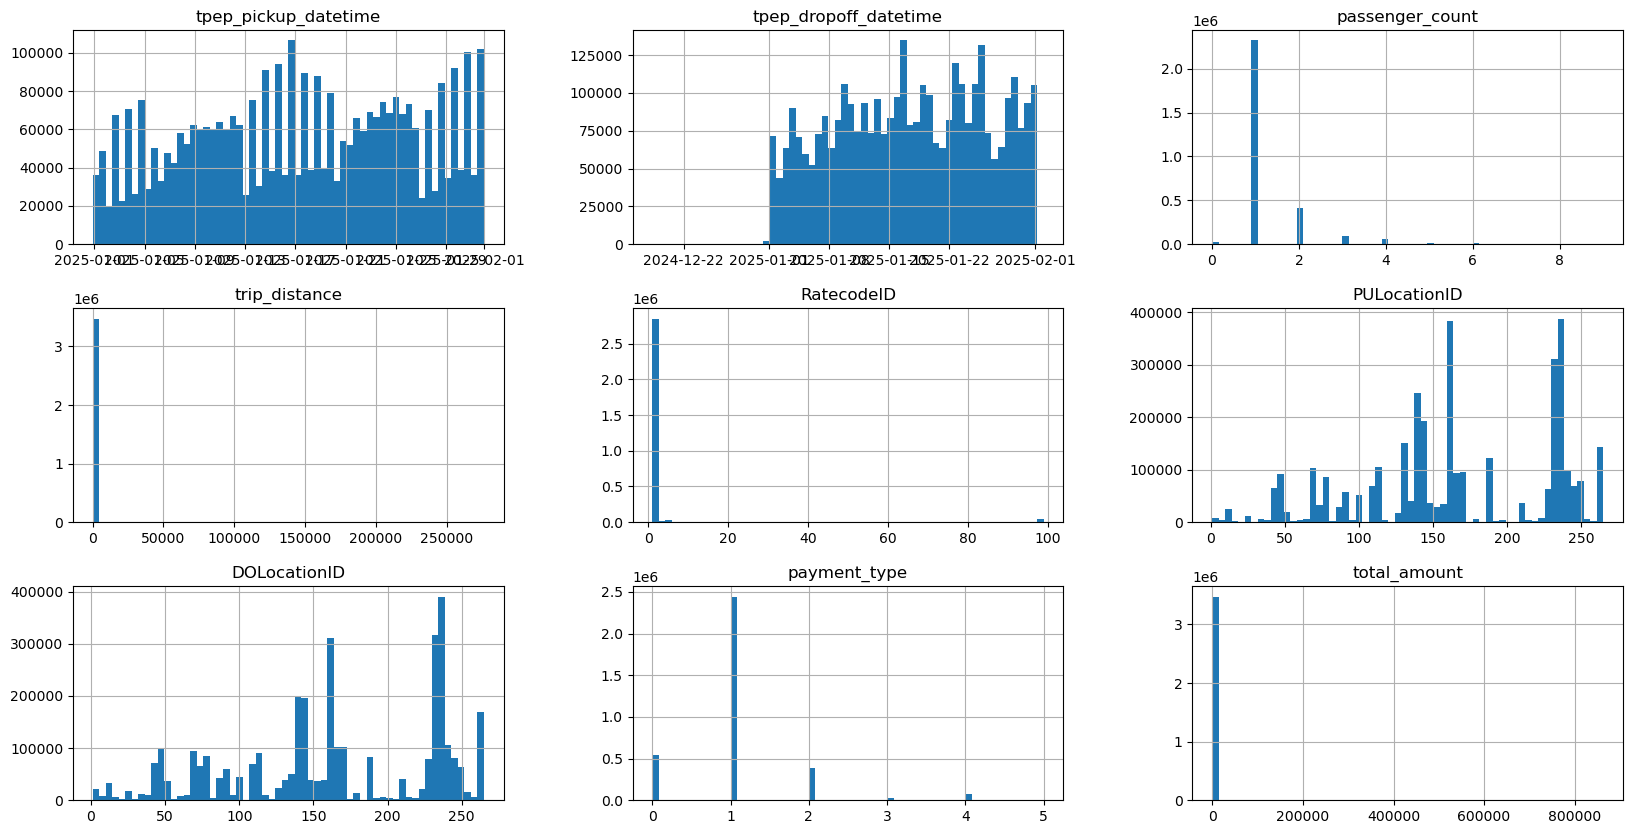

In [130]:
taxi_data.hist(figsize=(20, 10), bins=60)

In [131]:
taxi_data['RatecodeID'].value_counts()

RatecodeID
1.0     2756472
2.0       94420
99.0      41963
5.0       26501
3.0        8622
4.0        7092
6.0           7
Name: count, dtype: int64

<Axes: xlabel='index', ylabel='total_amount'>

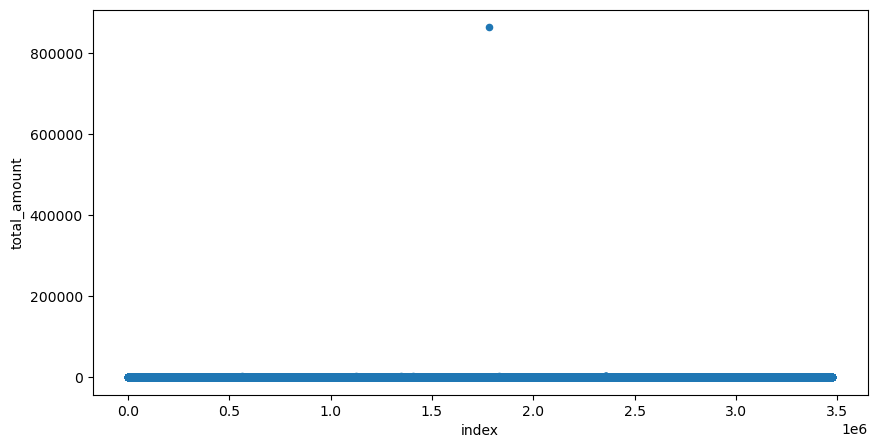

In [132]:
taxi_data.reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

<Axes: xlabel='index', ylabel='total_amount'>

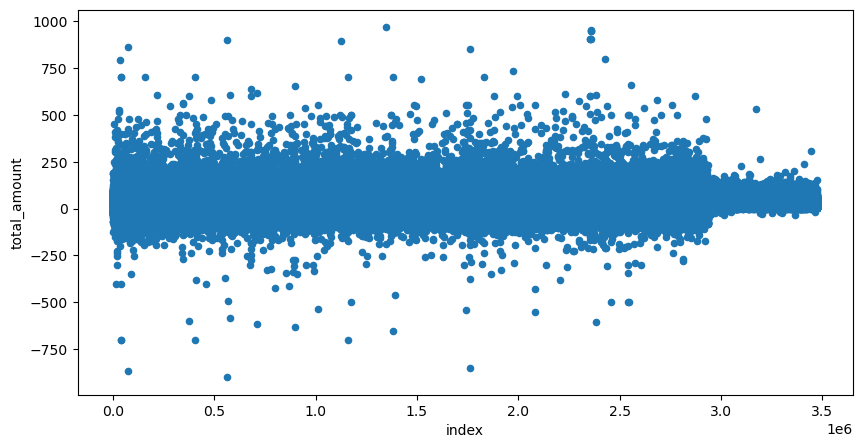

In [133]:
taxi_data[taxi_data['total_amount']<1000].reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))   

(63037, 9)


<Axes: xlabel='index', ylabel='total_amount'>

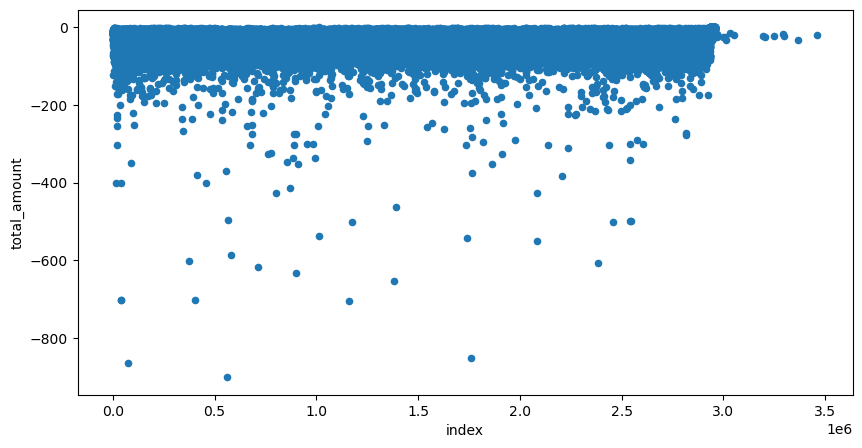

In [134]:
print(taxi_data[taxi_data['total_amount']<0].shape)
taxi_data[taxi_data['total_amount']<0].reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

In [135]:
taxi_data[taxi_data['total_amount']<0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
17,2025-01-01 00:01:41,2025-01-01 00:07:14,1.0,0.71,1.0,79,107,2,-8.54
22,2025-01-01 00:55:54,2025-01-01 01:00:38,1.0,0.69,1.0,137,233,4,-11.50
104,2025-01-01 00:56:12,2025-01-01 01:15:00,1.0,0.97,1.0,161,170,4,-21.30
149,2025-01-01 00:55:53,2025-01-01 01:06:49,1.0,1.42,1.0,79,45,2,-17.10
202,2025-01-01 00:29:35,2025-01-01 00:36:02,1.0,0.60,1.0,79,148,4,-12.20


In [136]:
taxi_data[taxi_data['total_amount']<0]['payment_type'].value_counts()

payment_type
4    37410
2    14111
3     8080
0     3421
1       15
Name: count, dtype: int64

<Axes: >

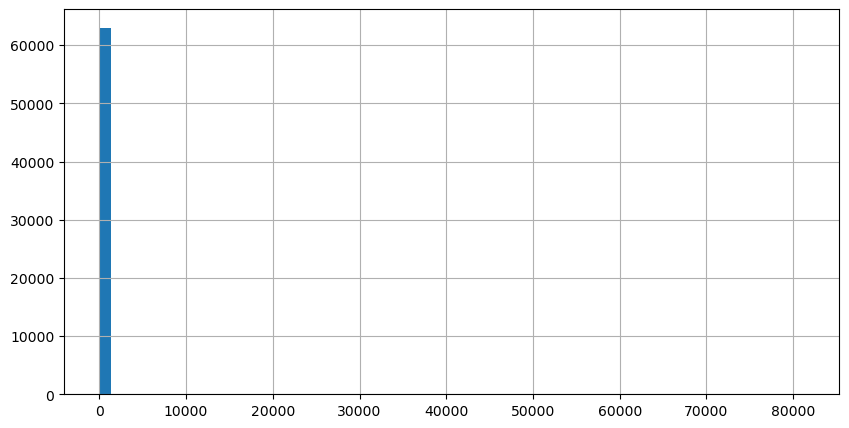

In [137]:
taxi_data[taxi_data['total_amount']<0]['trip_distance'].hist(bins=60, figsize=(10,5))

In [138]:
print(taxi_data[taxi_data['total_amount']==0].shape)
taxi_data[taxi_data['total_amount']==0].head()

(559, 9)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
10261,2025-01-01 01:30:13,2025-01-01 01:30:31,1.0,0.00,1.0,226,226,2,0.0
18189,2025-01-01 03:57:21,2025-01-01 04:02:26,1.0,0.40,1.0,158,125,3,0.0
19155,2025-01-01 03:27:25,2025-01-01 03:43:43,1.0,3.50,1.0,144,163,4,0.0
21300,2025-01-01 04:03:25,2025-01-01 04:11:42,2.0,4.69,1.0,255,97,2,0.0
21920,2025-01-01 04:24:55,2025-01-01 04:29:57,4.0,1.72,1.0,7,7,2,0.0


In [139]:
taxi_data[taxi_data['total_amount']==0]['payment_type'].value_counts()

payment_type
4    238
3    155
1     78
0     47
2     40
5      1
Name: count, dtype: int64

<Axes: >

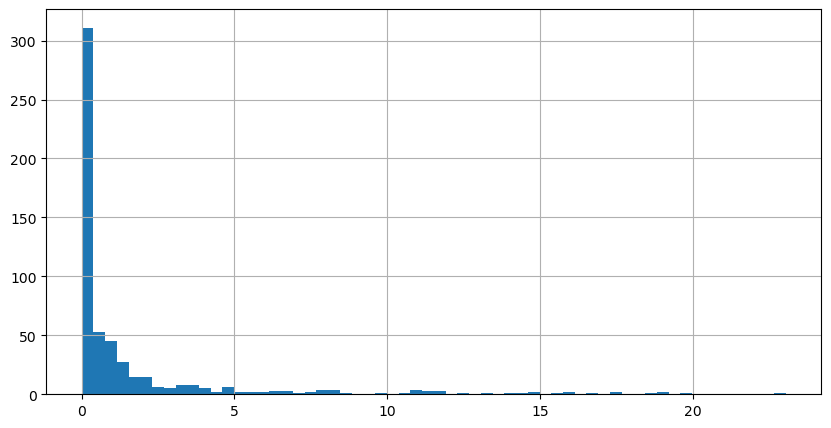

In [140]:
taxi_data[taxi_data['total_amount']==0]['trip_distance'].hist(bins=60, figsize=(10,5))

In [141]:
taxi_data[taxi_data['total_amount']==0]['trip_distance'].value_counts()

trip_distance
0.00     262
0.10      19
0.50      17
0.40      15
0.30      14
        ... 
1.46       1
6.60       1
1.72       1
1.45       1
14.68      1
Name: count, Length: 112, dtype: int64

<Axes: xlabel='index', ylabel='total_amount'>

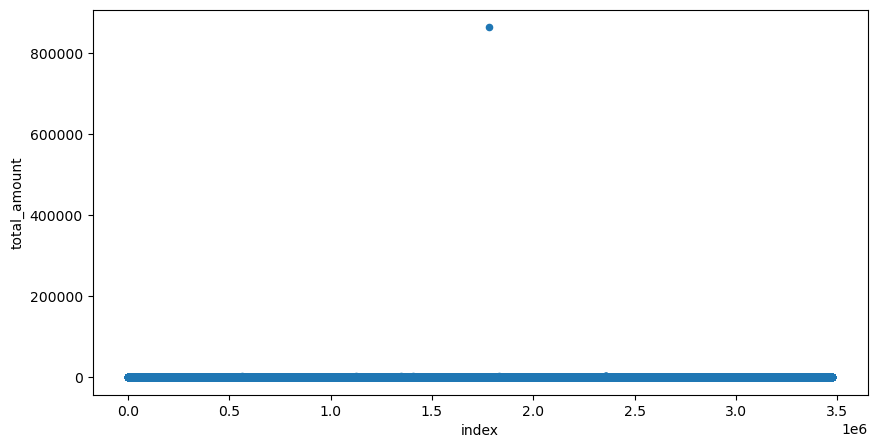

In [142]:
taxi_data.reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

In [143]:
taxi_data[taxi_data['total_amount']>250].shape

(945, 9)

In [144]:
taxi_data['total_amount'].mean()

np.float64(25.61129169728817)

## 3. Data Cleaning <a id='data_cleaning'></a>
[Back to top](#structure_of_project)

In [145]:
taxi_data_filtered = taxi_data.loc[(taxi_data['total_amount'] >= 0) & (taxi_data['total_amount'] < 250)].copy()

In [146]:
print(taxi_data.shape)
taxi_data_filtered.shape

(3475226, 9)


(3411243, 9)

In [147]:
taxi_data_filtered.isna().sum()

tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          536725
trip_distance                 0
RatecodeID               536725
PULocationID                  0
DOLocationID                  0
payment_type                  0
total_amount                  0
dtype: int64

In [148]:
print(taxi_data_filtered['passenger_count'].value_counts(dropna=False))

passenger_count
1.0    2277050
NaN     536725
2.0     397594
3.0      89015
4.0      56519
0.0      24644
5.0      17714
6.0      11964
8.0         11
7.0          4
9.0          3
Name: count, dtype: int64


In [149]:
taxi_data_filtered[taxi_data_filtered['RatecodeID'].isnull()]['passenger_count'].value_counts(dropna=False)

passenger_count
NaN    536725
Name: count, dtype: int64

In [150]:
print(taxi_data_filtered['passenger_count'].unique())
print(taxi_data_filtered['RatecodeID'].unique())

[ 1.  3.  2.  0.  4.  9.  6.  5.  8.  7. nan]
[ 1.  5. 99.  2.  4.  3.  6. nan]


In [151]:
taxi_data_filtered[taxi_data_filtered['RatecodeID'].isna() & taxi_data_filtered['passenger_count'].isna()].shape

(536725, 9)

In [152]:
taxi_data_filtered['RatecodeID'] = taxi_data_filtered['RatecodeID'].fillna(99)
taxi_data_filtered['passenger_count'] = taxi_data_filtered['passenger_count'].fillna(0.0)

In [153]:
print(taxi_data_filtered['RatecodeID'].value_counts(dropna=False))
print(taxi_data_filtered['passenger_count'].value_counts(dropna=False))

RatecodeID
1.0     2703192
99.0     578660
2.0       90776
5.0       24547
3.0        7908
4.0        6153
6.0           7
Name: count, dtype: int64
passenger_count
1.0    2277050
0.0     561369
2.0     397594
3.0      89015
4.0      56519
5.0      17714
6.0      11964
8.0         11
7.0          4
9.0          3
Name: count, dtype: int64


In [154]:
print(taxi_data_filtered['RatecodeID'].isna().sum())
print(taxi_data_filtered['passenger_count'].isna().sum())

0
0


In [155]:
taxi_data_filtered.isna().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
total_amount             0
dtype: int64

## 4. Data Preparation <a id='data_preparation'></a>
[Back to top](#structure_of_project)

In [156]:
taxi_data_prepared = taxi_data_filtered.copy()

In [157]:
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
total_amount                    float64
dtype: object

In [195]:
taxi_data_prepared['passenger_count'] = taxi_data_prepared['passenger_count'].astype(int)
taxi_data_prepared.loc[:, 'RatecodeID'] = taxi_data_prepared.loc[:, 'RatecodeID'].astype(str)
taxi_data_prepared.loc[:, 'PULocationID'] = taxi_data_prepared.loc[:, 'PULocationID'].astype(str)
taxi_data_prepared.loc[:, 'DOLocationID'] = taxi_data_prepared.loc[:, 'DOLocationID'].astype(str)
taxi_data_prepared.loc[:, 'payment_type'] = taxi_data_prepared.loc[:, 'payment_type'].astype(str)

In [159]:
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                   int64
trip_distance                   float64
RatecodeID                       object
PULocationID                     object
DOLocationID                     object
payment_type                     object
total_amount                    float64
dtype: object

In [160]:
taxi_data_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2025-01-01 00:18:38,2025-01-01 00:26:59,1,1.60,1.0,229,237,1,18.00
1,2025-01-01 00:32:40,2025-01-01 00:35:13,1,0.50,1.0,236,237,1,12.12
2,2025-01-01 00:44:04,2025-01-01 00:46:01,1,0.60,1.0,141,141,1,12.10
3,2025-01-01 00:14:27,2025-01-01 00:20:01,3,0.52,1.0,244,244,2,9.70
4,2025-01-01 00:21:34,2025-01-01 00:25:06,3,0.66,1.0,244,116,2,8.30


In [161]:
taxi_data_prepared['transaction_date'] = pd.to_datetime(taxi_data_prepared['tpep_pickup_datetime'].dt.date)

taxi_data_prepared['transaction_year'] = taxi_data_prepared['tpep_pickup_datetime'].dt.year
taxi_data_prepared['transaction_month'] = taxi_data_prepared['tpep_pickup_datetime'].dt.month
taxi_data_prepared['transaction_day'] = taxi_data_prepared['tpep_pickup_datetime'].dt.day
taxi_data_prepared['transaction_hour'] = taxi_data_prepared['tpep_pickup_datetime'].dt.hour

In [162]:
taxi_data_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,transaction_date,transaction_year,transaction_month,transaction_day,transaction_hour
0,2025-01-01 00:18:38,2025-01-01 00:26:59,1,1.60,1.0,229,237,1,18.00,2025-01-01,2025,1,1,0
1,2025-01-01 00:32:40,2025-01-01 00:35:13,1,0.50,1.0,236,237,1,12.12,2025-01-01,2025,1,1,0
2,2025-01-01 00:44:04,2025-01-01 00:46:01,1,0.60,1.0,141,141,1,12.10,2025-01-01,2025,1,1,0
3,2025-01-01 00:14:27,2025-01-01 00:20:01,3,0.52,1.0,244,244,2,9.70,2025-01-01,2025,1,1,0
4,2025-01-01 00:21:34,2025-01-01 00:25:06,3,0.66,1.0,244,116,2,8.30,2025-01-01,2025,1,1,0


array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'total_amount'}>,
        <Axes: title={'center': 'transaction_date'}>],
       [<Axes: title={'center': 'transaction_year'}>,
        <Axes: title={'center': 'transaction_month'}>,
        <Axes: title={'center': 'transaction_day'}>],
       [<Axes: title={'center': 'transaction_hour'}>, <Axes: >, <Axes: >]],
      dtype=object)

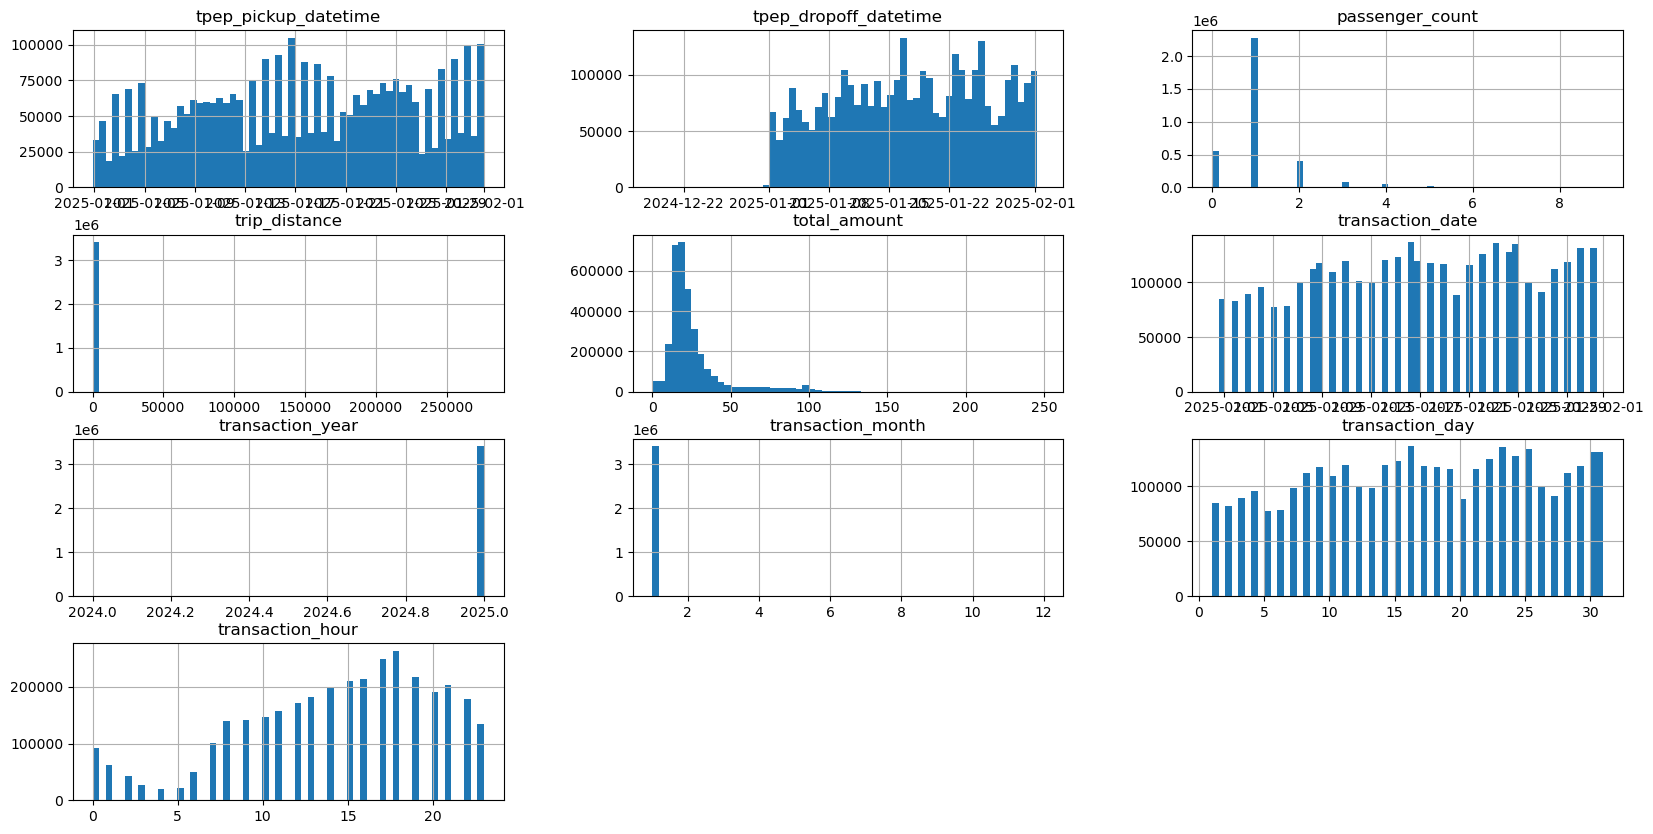

In [163]:
taxi_data_prepared.hist(figsize=(20,10), bins=60)

In [164]:
taxi_data_prepared[taxi_data_prepared['transaction_year']<2025].value_counts().sum()

np.int64(21)

In [165]:
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared['transaction_year']==2025]
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared['transaction_month']==1]

In [166]:
categorical_columns = ['PULocationID', 'transaction_date', 'transaction_month', 'transaction_day', 'transaction_hour']
numerical_columns = ['trip_distance', 'total_amount']
all_needed_columns = categorical_columns + numerical_columns

In [167]:
main_taxi_df = taxi_data_prepared[all_needed_columns]
print(main_taxi_df.shape)
main_taxi_df.head()

(3411221, 7)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount
0,229,2025-01-01,1,1,0,1.60,18.00
1,236,2025-01-01,1,1,0,0.50,12.12
2,141,2025-01-01,1,1,0,0.60,12.10
3,244,2025-01-01,1,1,0,0.52,9.70
4,244,2025-01-01,1,1,0,0.66,8.30


In [168]:
taxi_grouped_by_region = main_taxi_df.groupby(categorical_columns).mean().reset_index()
taxi_grouped_by_region['count_of_transactions'] = main_taxi_df.groupby(categorical_columns).count().reset_index()['total_amount']
print(taxi_grouped_by_region.shape)
taxi_grouped_by_region.head()

(96626, 8)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2025-01-01,1,1,6,0.100000,115.000,1
1,1,2025-01-01,1,1,9,0.000000,132.510,4
2,1,2025-01-01,1,1,12,0.000000,106.200,2
3,1,2025-01-01,1,1,13,1.333333,56.400,3
4,1,2025-01-01,1,1,14,2.160000,70.205,2


<Axes: >

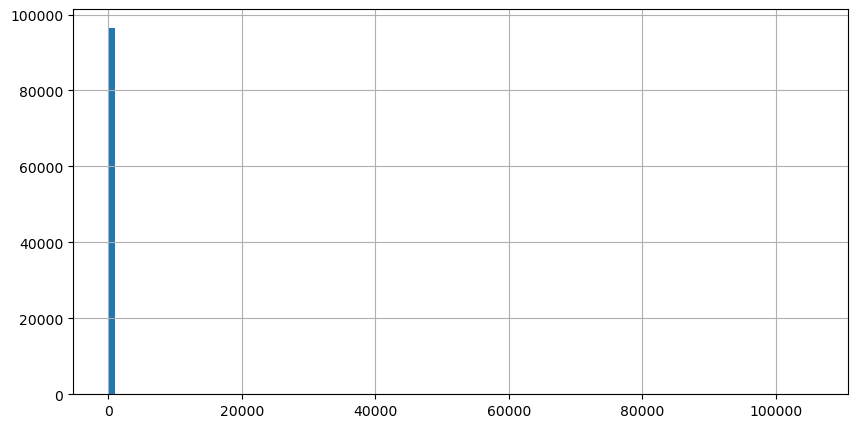

In [169]:
taxi_grouped_by_region['trip_distance'].hist(bins=100, figsize=(10,5))

<Axes: >

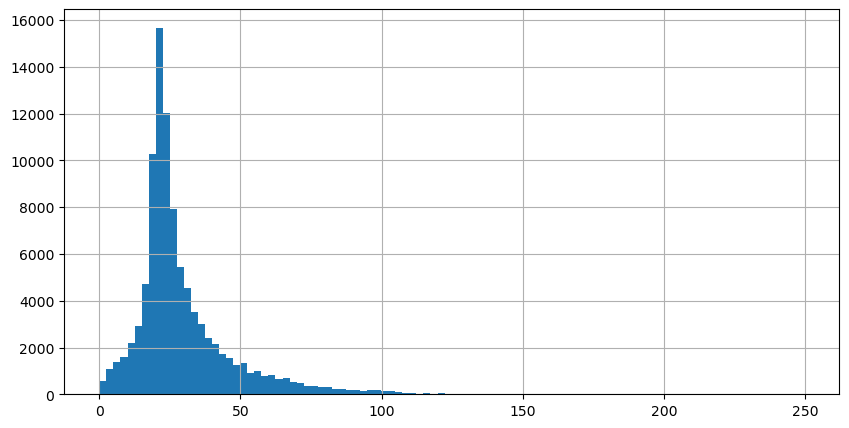

In [170]:
taxi_grouped_by_region['total_amount'].hist(bins=100, figsize=(10,5))

## 5. Benchmark Model <a id='benchmark_model'></a>
[Back to top](#structure_of_project)

In [171]:
data_for_benchmark_model = taxi_grouped_by_region.copy()

In [172]:
categorical_features_benchmark = ['PULocationID', 'transaction_month', 'transaction_day', 'transaction_hour']
input_features_benchmark = categorical_features_benchmark
target_feature_benchmark = 'total_amount'

### 5.1 Train-test split <a id='train_test_split'></a>

In [173]:
X_bench = data_for_benchmark_model[input_features_benchmark]
y_bench = data_for_benchmark_model[target_feature_benchmark]

# one-hot encode
X_bench = pd.get_dummies(X_bench)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.33, random_state=42)

### 5.2 Fit a model to the data <a id='fit_model_to_data'></a>

In [174]:
tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_b, y_train_b)

DecisionTreeRegressor(max_depth=10)

### 5.3 Model evaluation <a id='model_evaluation'></a>

In [175]:
model_at_hand = tree

y_pred_b = model_at_hand.predict(X_test_b)

print('mean_absolute_error', mean_absolute_error(y_test_b, y_pred_b))
print('mean_squared_error', mean_squared_error(y_test_b, y_pred_b))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test_b, y_pred_b)))
print('r2', r2_score(y_test_b, y_pred_b))

mean_absolute_error 10.844626040320264
mean_squared_error 269.99896842738025
root_mean_squared_error 16.431645335369804
r2 0.22116102005659388


<Axes: xlabel='true', ylabel='pred'>

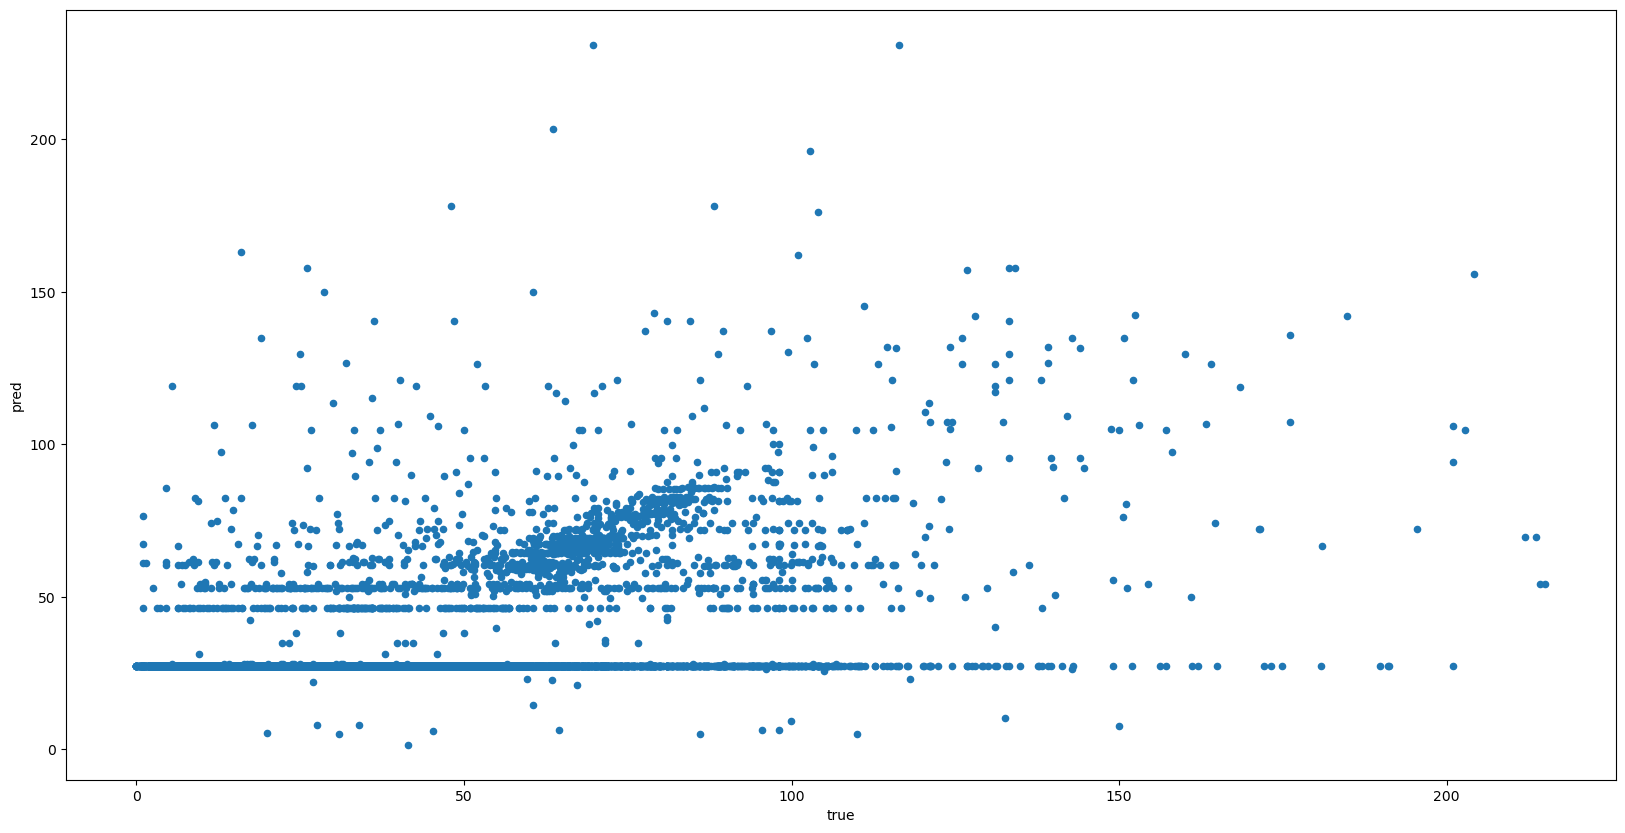

In [176]:
data = {'true': y_test_b, 'pred': y_pred_b}

results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

## 6. Feature Engineering <a id='feature_engineering'></a>
[Back to top](#structure_of_project)

In [177]:
taxi_grouped_by_region.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2025-01-01,1,1,6,0.100000,115.000,1
1,1,2025-01-01,1,1,9,0.000000,132.510,4
2,1,2025-01-01,1,1,12,0.000000,106.200,2
3,1,2025-01-01,1,1,13,1.333333,56.400,3
4,1,2025-01-01,1,1,14,2.160000,70.205,2


In [178]:
data_with_new_features = taxi_grouped_by_region.copy()

In [179]:
data_with_new_features['transaction_week_day'] = data_with_new_features['transaction_date'].dt.weekday
data_with_new_features['weekend'] = data_with_new_features['transaction_week_day'].apply(lambda x: True if x==5 or x==6 else False)

In [180]:
cal = USFederalHolidayCalendar()

holidays = pd.to_datetime(cal.holidays(start='2024', end='2026').date)
data_with_new_features.dtypes
data_with_new_features['is_holiday'] = data_with_new_features['transaction_date'].isin(holidays)

In [181]:
data_with_new_features.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday
0,1,2025-01-01,1,1,6,0.100000,115.000,1,2,False,True
1,1,2025-01-01,1,1,9,0.000000,132.510,4,2,False,True
2,1,2025-01-01,1,1,12,0.000000,106.200,2,2,False,True
3,1,2025-01-01,1,1,13,1.333333,56.400,3,2,False,True
4,1,2025-01-01,1,1,14,2.160000,70.205,2,2,False,True


In [182]:
zone_lookup = zone_lookup[['LocationID', 'Borough']]
zone_lookup['LocationID'] = zone_lookup['LocationID'].astype(str)
zone_lookup.head()

,LocationID,Borough
0,1,EWR
1,2,Queens
2,3,Bronx
3,4,Manhattan
4,5,Staten Island


In [183]:
data_with_new_features = data_with_new_features.merge(zone_lookup, left_on='PULocationID', right_on='LocationID', how='left')
data_with_new_features.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,LocationID,Borough
0,1,2025-01-01,1,1,6,0.100000,115.000,1,2,False,True,1,EWR
1,1,2025-01-01,1,1,9,0.000000,132.510,4,2,False,True,1,EWR
2,1,2025-01-01,1,1,12,0.000000,106.200,2,2,False,True,1,EWR
3,1,2025-01-01,1,1,13,1.333333,56.400,3,2,False,True,1,EWR
4,1,2025-01-01,1,1,14,2.160000,70.205,2,2,False,True,1,EWR


In [264]:
data_with_new_features['Borough'].value_counts(dropna=False)

Borough
Manhattan        42914
Brooklyn         22165
Queens           20930
Bronx             8914
Unknown            687
NaN                559
EWR                230
Staten Island      227
Name: count, dtype: int64

In [266]:
data_with_new_features['Borough'] = data_with_new_features['Borough'].fillna('Unknown')

In [267]:
nyc = Point(40.7128, -74.0060)
data = Hourly(nyc, start=datetime(2025, 1, 1), end=datetime(2025, 1, 31))
nyc_weather = data.fetch()

In [268]:
nyc_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 721 entries, 2025-01-01 00:00:00 to 2025-01-31 00:00:00
Freq: h
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    721 non-null    Float64
 1   dwpt    721 non-null    Float64
 2   rhum    721 non-null    Float64
 3   prcp    721 non-null    Float64
 4   snow    0 non-null      Float64
 5   wdir    721 non-null    Float64
 6   wspd    721 non-null    Float64
 7   wpgt    0 non-null      Float64
 8   pres    721 non-null    Float64
 9   tsun    0 non-null      Float64
 10  coco    721 non-null    Float64
dtypes: Float64(11)
memory usage: 75.3 KB


In [269]:
nyc_weather.rename(columns={
    'temp': 'temperature',
    'rhum': 'humidity',
    'wspd': 'wind_speed',
    'coco': 'cloud_cover',
    'prcp': 'amount_of_precipitation'
}, inplace=True)
nyc_weather.drop(columns=['dwpt', 'snow', 'wdir', 'pres', 'tsun', 'wpgt'], inplace=True)

In [270]:
nyc_weather.head()

,temperature,humidity,amount_of_precipitation,wind_speed,cloud_cover
time,,,,,
2025-01-01 00:00:00,9.0,74.0,0.0,28.0,3.0
2025-01-01 01:00:00,9.4,74.0,0.9,27.7,8.0
2025-01-01 02:00:00,8.3,90.0,2.5,5.4,9.0
2025-01-01 03:00:00,8.0,92.0,1.5,18.4,9.0
2025-01-01 04:00:00,7.8,94.0,4.7,27.7,9.0


In [271]:
nyc_weather.dtypes

temperature                Float64
humidity                   Float64
amount_of_precipitation    Float64
wind_speed                 Float64
cloud_cover                Float64
dtype: object

In [272]:
nyc_weather['amount_of_precipitation'].value_counts(dropna=False)

amount_of_precipitation
0.0    691
0.1      7
0.2      5
0.3      5
0.9      3
0.7      2
0.5      2
2.5      1
1.5      1
4.7      1
0.4      1
0.8      1
2.3      1
Name: count, dtype: Int64

In [273]:
nyc_weather['cloud_cover'].value_counts(dropna=False)

cloud_cover
3.0     366
1.0     218
2.0     105
15.0      9
14.0      6
7.0       4
8.0       3
9.0       3
12.0      3
5.0       2
17.0      1
16.0      1
Name: count, dtype: Int64

In [274]:
nyc_weather.isna().sum()

temperature                0
humidity                   0
amount_of_precipitation    0
wind_speed                 0
cloud_cover                0
dtype: int64

array([[<Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'amount_of_precipitation'}>,
        <Axes: title={'center': 'wind_speed'}>],
       [<Axes: title={'center': 'cloud_cover'}>, <Axes: >]], dtype=object)

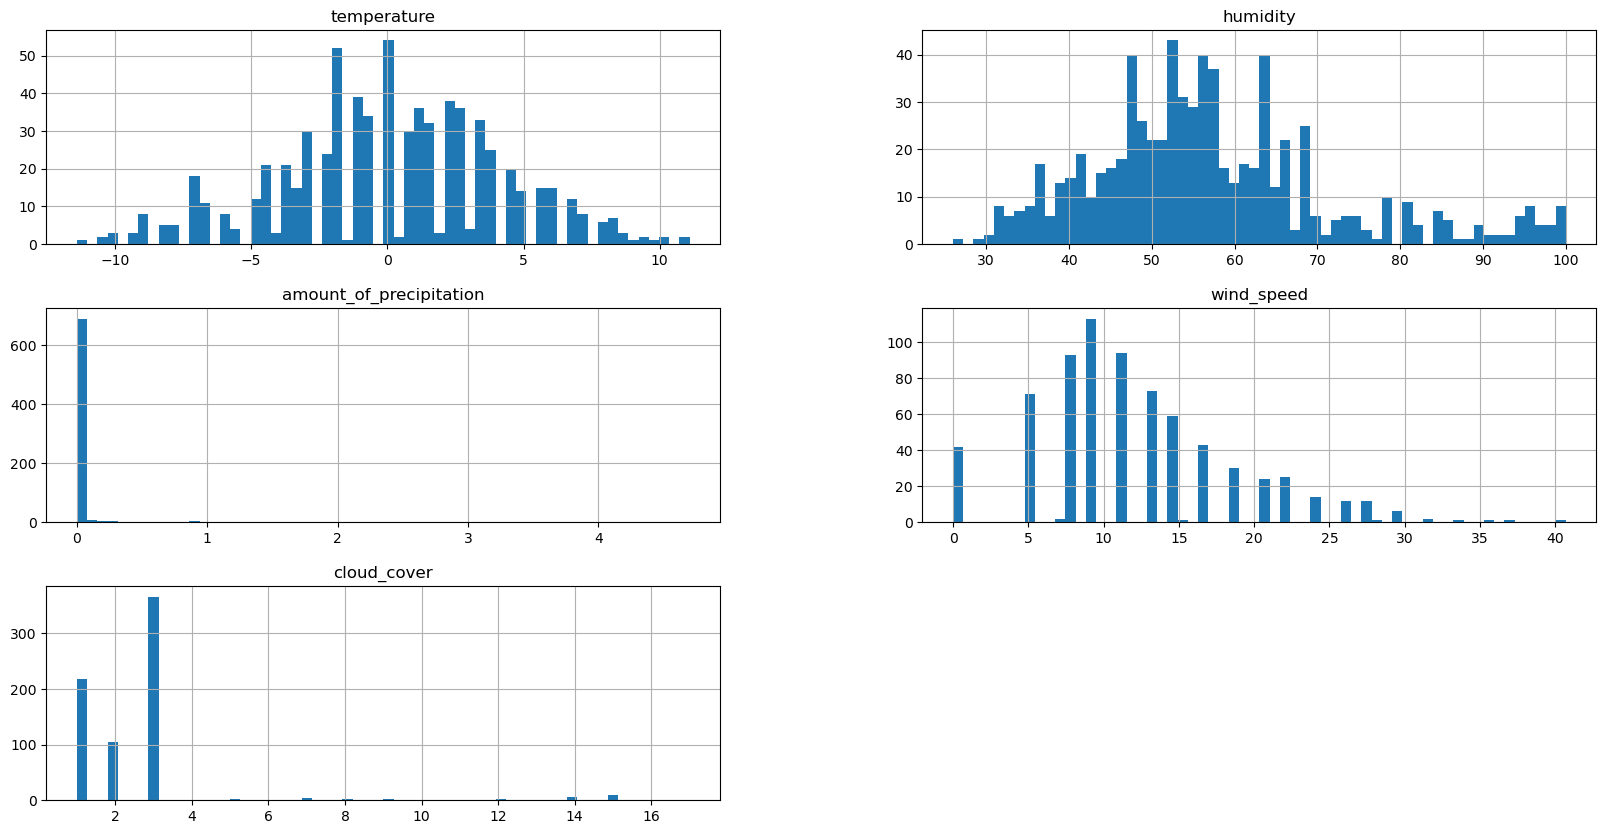

In [275]:
nyc_weather.hist(bins=60, figsize=(20,10))

In [276]:
nyc_weather.shape

(721, 5)

In [277]:
nyc_weather = nyc_weather.reset_index()

In [278]:
print(nyc_weather.columns)

Index(['time', 'temperature', 'humidity', 'amount_of_precipitation',
       'wind_speed', 'cloud_cover'],
      dtype='object')


In [279]:
nyc_weather = nyc_weather.rename(columns={'time': 'weather_datetime'})

In [280]:
nyc_weather['weather_datetime'] = pd.to_datetime(nyc_weather['weather_datetime'])

In [281]:
nyc_weather.loc[:,'weather_datetime'] = pd.to_datetime(nyc_weather.loc[:,'weather_datetime'])
nyc_weather['hour'] = nyc_weather['weather_datetime'].dt.hour
nyc_weather['month'] = nyc_weather['weather_datetime'].dt.month
nyc_weather['day'] = nyc_weather['weather_datetime'].dt.day

In [282]:
nyc_weather.head()

,weather_datetime,temperature,humidity,amount_of_precipitation,wind_speed,cloud_cover,hour,month,day
0,2025-01-01 00:00:00,9.0,74.0,0.0,28.0,3.0,0,1,1
1,2025-01-01 01:00:00,9.4,74.0,0.9,27.7,8.0,1,1,1
2,2025-01-01 02:00:00,8.3,90.0,2.5,5.4,9.0,2,1,1
3,2025-01-01 03:00:00,8.0,92.0,1.5,18.4,9.0,3,1,1
4,2025-01-01 04:00:00,7.8,94.0,4.7,27.7,9.0,4,1,1


In [283]:
data_with_new_features.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,LocationID,Borough
0,1,2025-01-01,1,1,6,0.100000,115.000,1,2,False,True,1,EWR
1,1,2025-01-01,1,1,9,0.000000,132.510,4,2,False,True,1,EWR
2,1,2025-01-01,1,1,12,0.000000,106.200,2,2,False,True,1,EWR
3,1,2025-01-01,1,1,13,1.333333,56.400,3,2,False,True,1,EWR
4,1,2025-01-01,1,1,14,2.160000,70.205,2,2,False,True,1,EWR


In [284]:
nyc_taxi_with_weather = data_with_new_features.merge(nyc_weather, left_on = ['transaction_month','transaction_day','transaction_hour'], right_on = ['month','day','hour'], how='left')

print(nyc_taxi_with_weather.shape)
nyc_taxi_with_weather.head()

(96626, 22)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,...,Borough,weather_datetime,temperature,humidity,amount_of_precipitation,wind_speed,cloud_cover,hour,month,day
0,1,2025-01-01,1,1,6,0.100000,115.000,1,2,False,...,EWR,2025-01-01 06:00:00,8.3,98.0,0.0,14.8,3.0,6.0,1.0,1.0
1,1,2025-01-01,1,1,9,0.000000,132.510,4,2,False,...,EWR,2025-01-01 09:00:00,8.4,98.0,0.0,11.2,3.0,9.0,1.0,1.0
2,1,2025-01-01,1,1,12,0.000000,106.200,2,2,False,...,EWR,2025-01-01 12:00:00,5.8,96.0,0.0,13.0,1.0,12.0,1.0,1.0
3,1,2025-01-01,1,1,13,1.333333,56.400,3,2,False,...,EWR,2025-01-01 13:00:00,5.7,95.0,0.0,14.8,1.0,13.0,1.0,1.0
4,1,2025-01-01,1,1,14,2.160000,70.205,2,2,False,...,EWR,2025-01-01 14:00:00,7.0,91.0,0.0,18.4,1.0,14.0,1.0,1.0


In [285]:
nyc_taxi_with_weather = nyc_taxi_with_weather.drop(['weather_datetime','hour','month','day'], axis=1)

In [286]:
nyc_taxi_with_weather.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,LocationID,Borough,temperature,humidity,amount_of_precipitation,wind_speed,cloud_cover
0,1,2025-01-01,1,1,6,0.100000,115.000,1,2,False,True,1,EWR,8.3,98.0,0.0,14.8,3.0
1,1,2025-01-01,1,1,9,0.000000,132.510,4,2,False,True,1,EWR,8.4,98.0,0.0,11.2,3.0
2,1,2025-01-01,1,1,12,0.000000,106.200,2,2,False,True,1,EWR,5.8,96.0,0.0,13.0,1.0
3,1,2025-01-01,1,1,13,1.333333,56.400,3,2,False,True,1,EWR,5.7,95.0,0.0,14.8,1.0
4,1,2025-01-01,1,1,14,2.160000,70.205,2,2,False,True,1,EWR,7.0,91.0,0.0,18.4,1.0


In [287]:
nyc_taxi_with_weather.isna().sum()

PULocationID                  0
transaction_date              0
transaction_month             0
transaction_day               0
transaction_hour              0
trip_distance                 0
total_amount                  0
count_of_transactions         0
transaction_week_day          0
weekend                       0
is_holiday                    0
LocationID                    0
Borough                       0
temperature                3434
humidity                   3434
amount_of_precipitation    3434
wind_speed                 3434
cloud_cover                3434
dtype: int64

In [288]:
nyc_taxi_with_weather = nyc_taxi_with_weather.sort_values(['transaction_date','transaction_hour']).reset_index().drop('index',axis=1)

In [291]:
nyc_taxi_with_weather = nyc_taxi_with_weather.infer_objects(copy=False)
nyc_taxi_with_weather = nyc_taxi_with_weather.interpolate()
nyc_taxi_with_weather = nyc_taxi_with_weather.bfill()

nyc_taxi_with_weather.isna().sum()

PULocationID               0
transaction_date           0
transaction_month          0
transaction_day            0
transaction_hour           0
trip_distance              0
total_amount               0
count_of_transactions      0
transaction_week_day       0
weekend                    0
is_holiday                 0
LocationID                 0
Borough                    0
temperature                0
humidity                   0
amount_of_precipitation    0
wind_speed                 0
cloud_cover                0
dtype: int64

In [292]:
nyc_taxi_with_weather.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,LocationID,Borough,temperature,humidity,amount_of_precipitation,wind_speed,cloud_cover
0,10,2025-01-01,1,1,0,11.400000,37.220000,1,2,False,True,10,Queens,9.0,74.0,0.0,28.0,3.0
1,100,2025-01-01,1,1,0,4.239000,46.289000,10,2,False,True,100,Manhattan,9.0,74.0,0.0,28.0,3.0
2,106,2025-01-01,1,1,0,5.663333,34.806667,3,2,False,True,106,Brooklyn,9.0,74.0,0.0,28.0,3.0
3,107,2025-01-01,1,1,0,2.718710,25.030538,186,2,False,True,107,Manhattan,9.0,74.0,0.0,28.0,3.0
4,112,2025-01-01,1,1,0,4.761538,31.450000,13,2,False,True,112,Brooklyn,9.0,74.0,0.0,28.0,3.0


## 7. Model Training <a id='model_training'></a>
[Back to top](#structure_of_project)

In [293]:
data_for_model = nyc_taxi_with_weather.copy()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [298]:
categorical_features = ['PULocationID', 'transaction_month', 'transaction_day',
       'transaction_hour', 'transaction_week_day', 'weekend', 'is_holiday', 'Borough']
input_features = categorical_features + ['temperature', 'humidity', 'wind_speed', 'cloud_cover',
       'amount_of_precipitation']
target_feature = 'total_amount'

In [299]:
X = data_for_model[input_features]
y = data_for_model[target_feature]

# one-hot encode
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### 7.1 Desicion tree <a id='decision_tree'></a>

In [300]:
decision_tree = DecisionTreeRegressor(max_depth=10)
decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10)

In [301]:
model_at_hand = decision_tree

y_pred = model_at_hand.predict(X_test)

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

mean_absolute_error 9.728754913469862
mean_squared_error 251.95712694073003
root_mean_squared_error 15.873157434509684
r2 0.2682652082785296


<Axes: xlabel='true', ylabel='pred'>

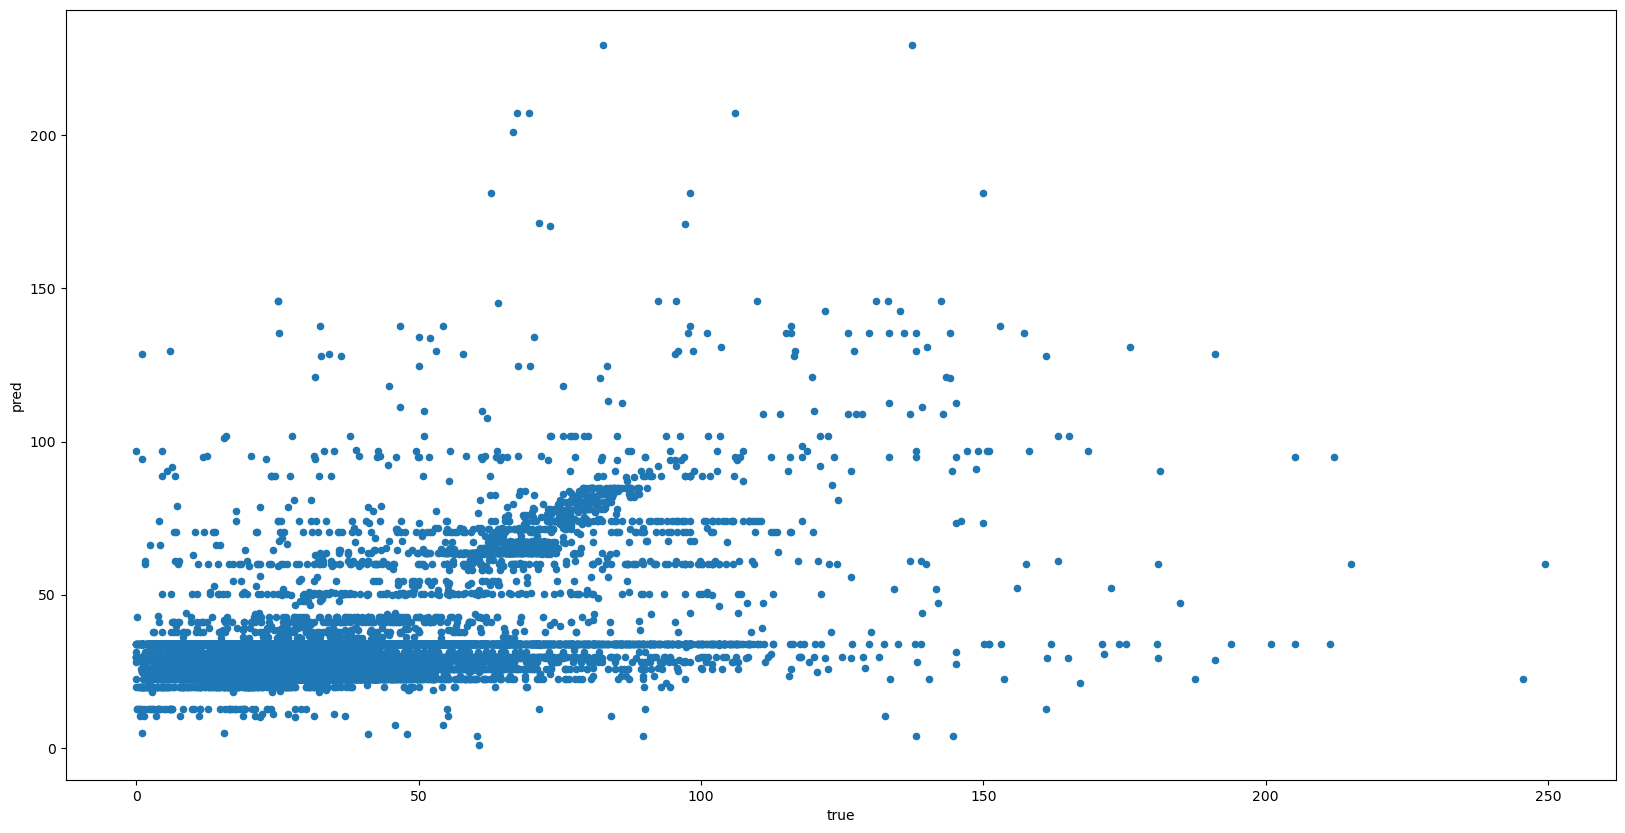

In [302]:
data = {'true': y_test, 'pred': y_pred}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

## OVERFIT

## UNDERFIT